In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
import os


from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
  
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


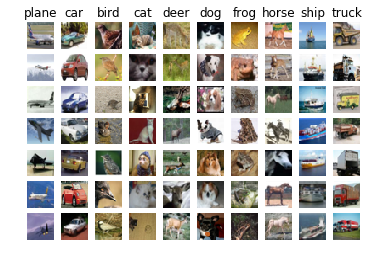

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
# You will keep coming back to this cell to add more functions as and when
# required. Right now it is very simple!
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """
    def train(self,X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def compute_distances_no_loops(self,X_test):
        blockSize = 10
        #It is giving mem error on processing all at once. Hence divding in blocks
        d = np.empty([X_test.shape[0],self.X_train.shape[0]])
        i=0
        while i+blockSize<X_test.shape[0]:
            curr_X_test = X_test[list(range(i,i+blockSize))]
            d[i:i+blockSize] = ((np.square(np.subtract(self.X_train,curr_X_test[:,np.newaxis])).sum(axis=2))**0.5)
            i=i+blockSize
        if i<X_test.shape[0]:
            curr_X_test = X_test[list(range(i,X_test.shape[0]))]
            d[i:X_test.shape[0]] = ((np.square(np.subtract(self.X_train,curr_X_test[:,np.newaxis])).sum(axis=2))**0.5)
        return d
        #return (np.square(np.subtract(self.X_train,X_test[:,np.newaxis])).sum(axis=2))**0.5
    def compute_distances_one_loop(self,X_test):
        d=[]
        for i in range(X_test.shape[0]):
            d.append((np.square(np.subtract(self.X_train,X_test[i])).sum(axis=1))**0.5)
        return np.array(d)
    def compute_distances_two_loops(self,X_test):
        d = np.zeros([X_test.shape[0],self.X_train.shape[0]])
        for i in range(d.shape[0]):
            for j in range(d.shape[1]):
                d[i][j] = self.getl2Distance(X_test[i],self.X_train[j])
        return d
    def predict_labels(self,dists,k):# need to get k smallest distances from each row
        ind = np.argsort(dists, axis=1)
        #print(ind)
        ind_k = ind[:,:k]
        #print(ind_k)
        predictions = []
        for indx in ind_k:
            predictions.append(self.y_train[indx])
        predictions = np.array(predictions)
        #print(predictions)
        finalClass = []
        for p in predictions:
            finalClass.append(np.bincount(p).argmax())
        finalClass = np.array(finalClass)
        #print(finalClass)
        return finalClass

    def getl2Distance(self,x,y):
        return (np.square(np.subtract(x,y)).sum())**0.5
    def __init__(self):
        pass
# Make sure to add train() in the classifier class before executing this cell
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [7]:
from timeit import default_timer as timer

In [10]:
# Make sure to add compute_distances_two_loops() in the classifier class 
# before executing this cell
start = timer()
dists = classifier.compute_distances_two_loops(X_test)
end = timer()
print("two loops time : ",end - start)
print(dists.shape)

two loops time :  34.161367
(500, 5000)


In [11]:

start = timer()
dists_one_Loop = classifier.compute_distances_one_loop(X_test)
end = timer()
print("one loop time : ",end - start)
dists_one_Loop.shape

start = timer()
dists_no_Loop = classifier.compute_distances_no_loops(X_test)
end = timer()
print("no loop time : ",end - start)
dists_no_Loop.shape


one loop time :  75.67612859999998
no loop time :  78.34294679999999


(500, 5000)

In [12]:
# Make sure to add predict_labels() in the classifier class 
# before executing this cell
klist = [1,3,5,7]
for k in klist:
    y_test_pred = classifier.predict_labels(dists, k)

    # Compute and print the fraction of correctly predicted examples
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print('For %d Got %d / %d correct => accuracy: %f' % (k,num_correct, num_test, accuracy))

For 1 Got 137 / 500 correct => accuracy: 0.274000
For 3 Got 136 / 500 correct => accuracy: 0.272000
For 5 Got 139 / 500 correct => accuracy: 0.278000
For 7 Got 137 / 500 correct => accuracy: 0.274000


In [8]:
def getithSet(data,i,eachFoldSize,folds):
    if(i==0):
        ithSet = data[i:i+eachFoldSize]
        remaining = data[i+eachFoldSize:]
        return ithSet,remaining
    elif(i==folds-1):
        ithSet = data[i*eachFoldSize:]
        remaining = data[0:i*eachFoldSize]
        return ithSet,remaining
    else:
        ithSet = data[i*eachFoldSize:(i+1)*eachFoldSize]
        remaining = np.concatenate((data[0:i*eachFoldSize],data[(i+1)*eachFoldSize:]),axis=0)
        return ithSet,remaining

In [12]:
from collections import defaultdict
klist = [1,3,5,7]
folds = 5
num_training = X_train.shape[0]
eachFoldSize = int(num_training/folds)
distDic = defaultdict(list) 
for k in klist:
    for i in range(folds): #number of folds
        X_val,X_train_fold = getithSet(X_train,i,eachFoldSize,folds)
        Y_val,Y_train_fold = getithSet(y_train,i,eachFoldSize,folds)
        classifier1 = KNearestNeighbor()
        print("training for k = ",k)
        classifier1.train(X_train_fold, Y_train_fold)
        dists_fold = classifier1.compute_distances_two_loops(X_val)
        distDic[k].append(dists_fold)

training for k =  1
training for k =  1
training for k =  1
training for k =  1
training for k =  1
training for k =  3
training for k =  3
training for k =  3
training for k =  3
training for k =  3
training for k =  5
training for k =  5
training for k =  5
training for k =  5
training for k =  5
training for k =  7
training for k =  7
training for k =  7
training for k =  7
training for k =  7


In [14]:
accuracyDic = defaultdict(list) 
for k in klist:
    for i in range(folds):
        currDists = distDic[k][i]
        y_test_pred_fold = classifier1.predict_labels(currDists, k)
        num_correct_fold = np.sum(y_test_pred_fold == Y_val)
        num_test_fold = Y_val.shape[0]
        accuracy = float(num_correct_fold) / num_test_fold
        accuracyDic[k].append(accuracy)
        print('For k = %d and fold= %d Got %d / %d correct => accuracy: %f' % (k,i,num_correct_fold, num_test_fold, accuracy))
        

For k = 1 and fold= 0 Got 109 / 1000 correct => accuracy: 0.109000
For k = 1 and fold= 1 Got 101 / 1000 correct => accuracy: 0.101000
For k = 1 and fold= 2 Got 93 / 1000 correct => accuracy: 0.093000
For k = 1 and fold= 3 Got 100 / 1000 correct => accuracy: 0.100000
For k = 1 and fold= 4 Got 266 / 1000 correct => accuracy: 0.266000
For k = 3 and fold= 0 Got 109 / 1000 correct => accuracy: 0.109000
For k = 3 and fold= 1 Got 99 / 1000 correct => accuracy: 0.099000
For k = 3 and fold= 2 Got 100 / 1000 correct => accuracy: 0.100000
For k = 3 and fold= 3 Got 85 / 1000 correct => accuracy: 0.085000
For k = 3 and fold= 4 Got 254 / 1000 correct => accuracy: 0.254000
For k = 5 and fold= 0 Got 99 / 1000 correct => accuracy: 0.099000
For k = 5 and fold= 1 Got 103 / 1000 correct => accuracy: 0.103000
For k = 5 and fold= 2 Got 106 / 1000 correct => accuracy: 0.106000
For k = 5 and fold= 3 Got 104 / 1000 correct => accuracy: 0.104000
For k = 5 and fold= 4 Got 280 / 1000 correct => accuracy: 0.280000

In [31]:
stdDev = []
for k in klist:
    currAcc = accuracyDic[k]
    stdDev.append(np.std(np.array(currAcc)))
    print("Average accuracy with k=%d is %f and standard deviation %f"% (k,sum(currAcc) / len(currAcc),np.std(np.array(currAcc)) ))
    

Average accuracy with k=1 is 0.133800 and standard deviation 0.066294
Average accuracy with k=3 is 0.129400 and standard deviation 0.062771
Average accuracy with k=5 is 0.138400 and standard deviation 0.070837
Average accuracy with k=7 is 0.143600 and standard deviation 0.066533


 - We are gettign maximum avg accuracy with k=7 

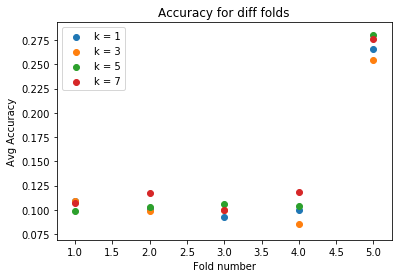

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
folds_list = [1,2,3,4,5]
for k in klist:
    legend = "k = "+str(k)
    plt.scatter(folds_list, accuracyDic[k],label=legend)
plt.xlabel("Fold number")
plt.ylabel("Avg Accuracy")
plt.title('Accuracy for diff folds')
plt.legend()

Text(0.5,1,'Standard dev for diff values of K')

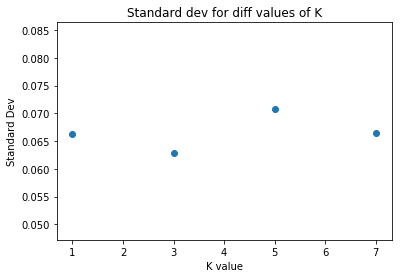

In [35]:
plt.scatter(klist, stdDev,label=legend)
plt.xlabel("K value")
plt.ylabel("Standard Dev")
plt.title("Standard dev for diff values of K")

#### Subtract mean from each pixel

In [50]:
X_train_sub_mean = X_train-np.mean(X_train)
X_test_sub_mean = X_test-np.mean(X_test)
Y_train_sub_mean = y_train
Y_test_sub_mean = y_test

In [53]:
classifier_sub_mean = KNearestNeighbor()
classifier_sub_mean.train(X_train_sub_mean, Y_train_sub_mean)
dists_sub_mean = classifier_sub_mean.compute_distances_two_loops(X_test_sub_mean)

In [54]:
klist = [1,3,5,7]
for k in klist:
    y_test_pred_sub_mean = classifier_sub_mean.predict_labels(dists_sub_mean, k)

    # Compute and print the fraction of correctly predicted examples
    num_correct_sub_mean = np.sum(y_test_pred_sub_mean == Y_test_sub_mean)
    num_test = Y_test_sub_mean.shape[0]
    accuracy_sub_mean = float(num_correct_sub_mean) / num_test
    print('For %d Got %d / %d correct => accuracy: %f' % (k,num_correct_sub_mean, num_test, accuracy_sub_mean))

For 1 Got 133 / 500 correct => accuracy: 0.266000
For 3 Got 140 / 500 correct => accuracy: 0.280000
For 5 Got 140 / 500 correct => accuracy: 0.280000
For 7 Got 134 / 500 correct => accuracy: 0.268000


 - There is a change in accuracy. Increased for k=3,5 decreased for k=1,7

 #### Subtract mean from each pixel axis = 0

In [64]:
X_train_sub_mean_1 = X_train-np.mean(X_train,axis=0)
X_test_sub_mean_1 = X_test-np.mean(X_train,axis=0)
Y_train_sub_mean_1 = y_train
Y_test_sub_mean_1 = y_test

In [65]:
classifier_sub_mean_1 = KNearestNeighbor()
classifier_sub_mean_1.train(X_train_sub_mean_1, Y_train_sub_mean_1)
dists_sub_mean_1 = classifier_sub_mean_1.compute_distances_two_loops(X_test_sub_mean_1)

In [66]:
klist = [1,3,5,7]
for k in klist:
    y_test_pred_sub_mean_1 = classifier_sub_mean_1.predict_labels(dists_sub_mean_1, k)

    # Compute and print the fraction of correctly predicted examples
    num_correct_sub_mean_1 = np.sum(y_test_pred_sub_mean_1 == Y_test_sub_mean_1)
    num_test = Y_test_sub_mean_1.shape[0]
    accuracy_sub_mean_1 = float(num_correct_sub_mean_1) / num_test
    print('For %d Got %d / %d correct => accuracy: %f' % (k,num_correct_sub_mean_1, num_test, accuracy_sub_mean_1))

For 1 Got 137 / 500 correct => accuracy: 0.274000
For 3 Got 136 / 500 correct => accuracy: 0.272000
For 5 Got 139 / 500 correct => accuracy: 0.278000
For 7 Got 137 / 500 correct => accuracy: 0.274000


 - The above results are exactly same as the one without subtracting any mean. No change in accuracy
 - This is because on subtracting mean pixel wise. We are not changing the relative distance between pixels hence there is no change in the results

 #### What is the time complexity of training using KNN classifier? What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?
 - There is no training time in KNN classifier O(1).
 - Testing time is O(m*d) where m is number of elements in training data and d is the dimension.
 - KNN is a non linear classifier. It can learn non linear boundaries too. It just looks at nearest points and classifies

#### Bonus: Explore what image features you can use to better the performance of KNN classifier.
 - We can apply knn on the edge image ( Can get it using laplacian operator)
 - Using PCA then apply KNN